In [1]:
import pandas as pd
import math
import numpy as np
from scipy import stats

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_theme(style='whitegrid')

In [2]:
data = pd.read_csv('data/data_train_DF.csv')
data.drop('Unnamed: 0', axis=1, inplace=True)

# Replacing clim1 and clim2 by wind
data['wind'] = np.sqrt(data.clim1**2+data.clim2**2)
data.drop(['clim1','clim2'], axis=1, inplace=True)

# Relative humidity
data['RH'] = 100 * np.exp(17.625*(data.clim3-273.15)/(data.clim3-39.11)) / np.exp(17.625*(data.clim4-273.15)/(data.clim4-39.11))

# Changin month to factor and dropping area
data.drop('area', axis=1, inplace=True)
data['month'] = data['month'].astype('category')

# Dropping NA in new dataframe
data_validation = data[data.BA.isna() | data.CNT.isna()]
data.dropna(inplace=True)
    
data.head(4)

,CNT,BA,lon,lat,year,month,lc1,lc2,lc3,lc4,...,clim3,clim4,clim5,clim6,clim7,clim8,clim9,clim10,wind,RH
0,0.0,0.0,-95.25,49.25,1993,3,0.000006,0.015857,0.000023,0.001299,...,265.457680,268.867126,-0.005898,9.187450e+06,-5231370.5,97849.906250,-0.000340,0.000448,0.277765,76.304978
1,0.0,0.0,-94.75,49.25,1993,3,0.000005,0.002749,0.000002,0.000234,...,265.521764,268.412354,-0.001131,6.993830e+06,-4851900.0,97954.703125,-0.000264,0.000462,0.232549,79.479839
2,0.0,0.0,-122.75,48.75,1993,3,0.002420,0.103964,0.003870,0.027099,...,276.699820,280.594666,-0.010519,1.052566e+07,-4860741.0,100808.468750,-0.001945,0.004545,1.281072,75.576717
3,3.0,8.0,-122.25,48.75,1993,3,0.002988,0.237442,0.004040,0.047382,...,274.943327,278.574371,-0.008420,9.359787e+06,-4653411.5,98474.648438,-0.001256,0.006174,0.963919,76.703795


In [3]:
# List of labels by type
clim_labels = ['altiMean', 'altiSD', 'clim3', 'clim4', 'clim5', 'clim6', 'clim7', 'clim8','clim9', 'clim10', 'wind', 'RH']
land_labels = ['lc1','lc2','lc3','lc4','lc5','lc6','lc7','lc8','lc9','lc10','lc11','lc12','lc13','lc14','lc15','lc16','lc17','lc18']

In [4]:
from sklearn.preprocessing import StandardScaler

# Splitting data to train/test
X_train = data[data.year.isin([1995,2005,2015])].drop('BA', axis=1)
y_train = data[data.year.isin([1995,2005,2015])][['BA']]
X_test  = data[data.year.isin([1997,2007])].drop('BA', axis=1)
y_test  = data[data.year.isin([1997,2007])][['BA']]

# Standardizing climate variables
scaler = StandardScaler()
X_train[clim_labels] = scaler.fit_transform(X_train[clim_labels])
X_test[clim_labels] = scaler.fit_transform(X_test[clim_labels])

In [5]:
# Adding mean CNT per voxel
mean_CNT_voxel = X_train.groupby(['lon','lat'])[['CNT']].mean()
X_train['mean_fire'] = X_train.apply(lambda x: mean_CNT_voxel.loc[x.lon,x.lat], axis=1)
X_test['mean_fire'] = X_test.apply(lambda x: mean_CNT_voxel.loc[x.lon,x.lat], axis=1)

In [6]:
X_train.head(4)

,CNT,lon,lat,year,month,lc1,lc2,lc3,lc4,lc5,...,clim4,clim5,clim6,clim7,clim8,clim9,clim10,wind,RH,mean_fire
49042,0.0,-95.25,49.25,1995,3,0.000006,0.016773,0.000025,0.001339,0.030603,...,-2.519617,0.681688,-2.509346,1.130469,0.637303,1.605676,-0.873895,-0.486991,0.900351,0.000000
49043,0.0,-94.75,49.25,1995,3,0.000005,0.002813,0.000002,0.000241,0.006006,...,-2.588345,1.493726,-3.020316,1.286596,0.652743,1.692425,-0.901202,-0.194048,1.188057,0.000000
49044,0.0,-122.75,48.75,1995,3,0.002336,0.103455,0.003785,0.027096,0.017803,...,-1.261020,-0.049669,-1.776900,0.565023,0.960175,0.010878,1.129725,0.761036,0.922191,0.714286
49045,4.0,-122.25,48.75,1995,3,0.002988,0.236517,0.004040,0.047353,0.035957,...,-1.504713,0.414177,-2.118623,0.681306,0.648842,0.752724,2.053845,0.000715,1.111186,2.047619


In [7]:
# Defining Thresholds and Scoring Function
u_CNT = list(range(0,11))+[2*x for x in range(6,16)]+[10*x for x in range(4,11)]
u_BA  = [0,1]+[10*x for x in range(1,11)]+[50*x for x in range(3,7)]+[400,500,1000,1500,2000,5000]+[10000*x for x in range(1,6)]+[100000]

w_CNT = [1-(1+(x+1)**2/1000)**(-1/4) for x in u_CNT] 
w_CNT = [x/w_CNT[-1] for x in w_CNT] 

w_BA  = [1-(1+(x+1)/1000)**(-1/4) for x in u_BA]
w_BA  = [x/w_BA[-1] for x in w_BA]

def cnt_score(y_test, prediction_dist):  
    S_CNT  = 0
    for i in range(len(actual)):
        S_CNT = S_CNT + np.sum([w_CNT[x]*(int(u_CNT[x]>=y_test.iloc[i])-prediction_dist.iloc[i,x])**2 for x in range(len(u_CNT))])
    return S_CNT

def ba_score(y_test, prediction_dist):  
    S_BA  = 0
    for i in range(len(y_test)):
        S_BA = S_BA + np.sum([w_BA[x]*(int(u_BA[x]>=y_test.iloc[i])-prediction_dist.iloc[i,x])**2 for x in range(len(u_BA))])
    return S_BA

In [8]:
# New y_train and y_test that represents intervals of BA :

# method 1 : replace extremes by max u_BA
new_y_train = pd.Categorical(pd.cut(y_train.BA, bins=[-1]+u_BA, right=True, labels=u_BA)).fillna(max(u_BA))
new_y_train = pd.DataFrame(new_y_train, columns=['threshold'], index=y_train.index)
new_y_test = pd.Categorical(pd.cut(y_test.BA, bins=[-1]+u_BA, right=True, labels=u_BA)).fillna(max(u_BA))
new_y_test = pd.DataFrame(new_y_test, columns=['threshold'], index=y_test.index)

# method 2 : replace extremes by -1
new2_y_train = pd.Categorical(pd.cut(y_train.BA, bins=[-1]+u_BA, right=True, labels=u_BA)).add_categories(-1).fillna(-1)
new2_y_train = pd.DataFrame(new2_y_train, columns=['threshold'], index=y_train.index)
new2_y_test = pd.Categorical(pd.cut(y_test.BA, bins=[-1]+u_BA, right=True, labels=u_BA)).add_categories(-1).fillna(-1)
new2_y_test = pd.DataFrame(new2_y_test, columns=['threshold'], index=y_test.index)

In [9]:
# Appoximation of the prediction distribution - log1p
def dist_log1p(prediction):
    ba_distribution = pd.DataFrame(data=0, index=np.arange(prediction.size), columns=u_BA)
    ba_distribution = ba_distribution.apply(lambda x: stats.norm.cdf(np.log1p(x.name), loc=prediction[x.index], scale=np.std(prediction)), result_type='expand')
    return ba_distribution

def dist_log(prediction):
    ba_distribution = pd.DataFrame(data=0, index=np.arange(prediction.size), columns=u_BA[1:])
    ba_distribution = ba_distribution.apply(lambda x: stats.norm.pdf(np.log(x.name), loc=prediction[x.index], scale=np.std(prediction)), result_type='expand')
    return ba_distribution

# Models
Trying some regression and classification models

In [10]:
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, balanced_accuracy_score
import sklearn.linear_model as lm

### Random Forest Regression

In [11]:
%%time

mRF = RandomForestRegressor(max_depth=5, n_estimators=500, n_jobs=8, bootstrap=False, random_state=42)
mRF.fit(X_train.drop('CNT', axis=1), np.log1p(y_train.BA))

prediction = mRF.predict(X_test.drop('CNT', axis=1))
ba_distribution = dist_log1p(prediction)
ba_distribution.to_csv('prediction_ba.csv', index=False)

## SCORE=4280

CPU times: user 5min 27s, sys: 338 ms, total: 5min 27s
Wall time: 42.9 s


### Lasso Enhanced Random Forest Regression

In [12]:
%%time

mLasso = lm.Lasso(alpha=0.1)
mLasso.fit(X_train.drop('CNT', axis=1), np.ravel(np.log1p(y_train)))

residuals = np.ravel(np.log1p(y_train))-mLasso.predict(X_train.drop('CNT', axis=1))

mRERF = RandomForestRegressor(max_depth=5, n_estimators=500, n_jobs=10, bootstrap=False, random_state=42)
mRERF.fit(X_train.drop('CNT', axis=1), residuals)

prediction = mLasso.predict(X_test.drop('CNT', axis=1)) + mRERF.predict(X_test.drop('CNT', axis=1))
ba_distribution = dist_log1p(prediction)
ba_distribution.to_csv('prediction_ba.csv', index=False)

## SCORE=4345

CPU times: user 6min 43s, sys: 424 ms, total: 6min 44s
Wall time: 42.1 s


### Random Forest Classifier - with/without CNT

In [13]:
%%time

mRFC0 = RandomForestClassifier(max_depth=5, n_estimators=1000, n_jobs=8, bootstrap=False, max_features=None, random_state=42)
mRFC0.fit(X_train.drop('CNT', axis=1), new_y_train.threshold)

ba_distribution = pd.DataFrame(mRFC0.predict_proba(X_test.drop('CNT', axis=1)), columns=u_BA).cumsum(axis=1)
ba_distribution.to_csv('prediction_ba.csv', index=False)

## SCORE=4079

CPU times: user 15min 34s, sys: 1.91 s, total: 15min 36s
Wall time: 2min


In [14]:
%%time

mRFC1 = RandomForestClassifier(max_depth=5, n_estimators=1000, n_jobs=8, bootstrap=False, max_features=None, random_state=42)
mRFC1.fit(X_train, new_y_train.threshold)

ba_distribution = pd.DataFrame(mRFC1.predict_proba(X_test), columns=u_BA).cumsum(axis=1)
ba_distribution.to_csv('prediction_ba.csv', index=False)

## SCORE=3720

CPU times: user 9min 13s, sys: 916 ms, total: 9min 14s
Wall time: 1min 12s


In [15]:
# What the output look like :
ba_distribution

,0,1,10,20,30,40,50,60,70,80,...,1000,1500,2000,5000,10000,20000,30000,40000,50000,100000
0,1.0,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.0,1.0,1.0,1.0
1,1.0,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.0,1.0,1.0,1.0
2,1.0,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.0,1.0,1.0,1.0
3,1.0,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.0,1.0,1.0,1.0
4,1.0,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49037,0.0,0.105109,0.555912,0.70073,0.770803,0.815474,0.848175,0.872117,0.886715,0.899562,...,0.984234,0.988905,0.991533,0.997372,0.999416,1.0,1.0,1.0,1.0,1.0
49038,0.0,0.105109,0.555912,0.70073,0.770803,0.815474,0.848175,0.872117,0.886715,0.899562,...,0.984234,0.988905,0.991533,0.997372,0.999416,1.0,1.0,1.0,1.0,1.0
49039,1.0,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.0,1.0,1.0,1.0
49040,0.0,0.105109,0.555912,0.70073,0.770803,0.815474,0.848175,0.872117,0.886715,0.899562,...,0.984234,0.988905,0.991533,0.997372,0.999416,1.0,1.0,1.0,1.0,1.0


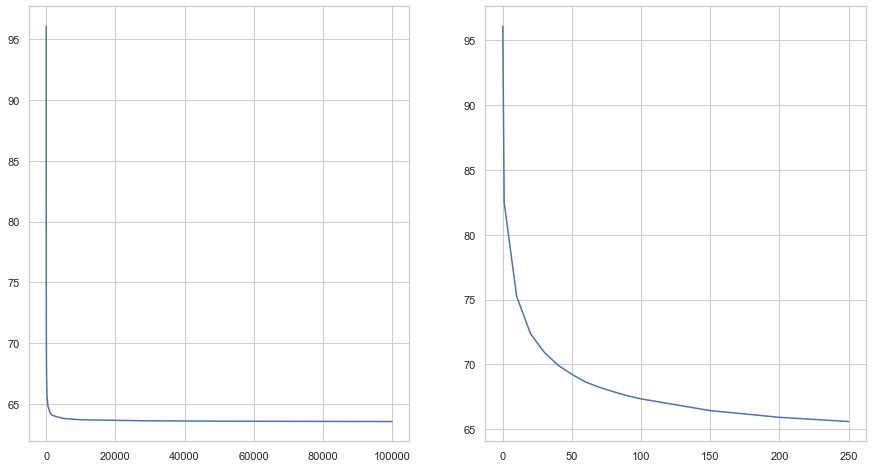

In [16]:
scores = [100*mRFC0.score(X_test[y_test.BA<=lv].drop('CNT', axis=1), new_y_test[y_test.BA<=lv].threshold) for lv in u_BA]

fig, ax = plt.subplots(1,2, figsize=(15,8))
ax[0].plot(u_BA, scores)
ax[1].plot(u_BA[0:15], scores[0:15]);

### Multi-layer Perceptron classifier

In [17]:
%%time

clf_MLP0 = MLPClassifier(max_iter=300, activation='relu', alpha=0.0001, learning_rate='adaptive', hidden_layer_sizes=100, random_state=42)
clf_MLP0.fit(X_train.drop('CNT', axis=1), new2_y_train.threshold)

ba_distribution = pd.DataFrame(clf_MLP0.predict_proba(X_test.drop('CNT', axis=1))[:,1:], columns=u_BA).cumsum(axis=1)
ba_distribution.to_csv('prediction_ba.csv', index=False)

# SCORE=3856

/Users/monginouira/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


CPU times: user 32min 29s, sys: 6.71 s, total: 32min 35s
Wall time: 4min 6s


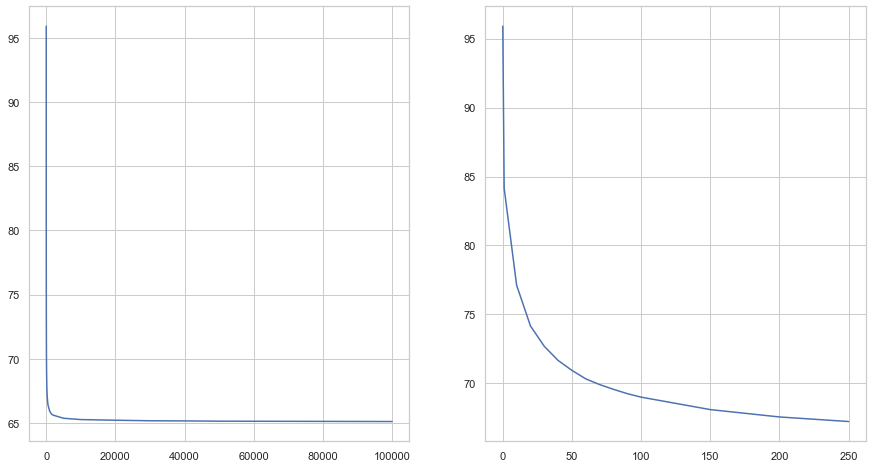

In [18]:
scores = [100*clf_MLP0.score(X_test[y_test.BA<=lv].drop('CNT', axis=1), new2_y_test[y_test.BA<=lv].threshold) for lv in u_BA]

fig, ax = plt.subplots(1,2, figsize=(15,8))
ax[0].plot(u_BA, scores)
ax[1].plot(u_BA[0:15], scores[0:15]);

In [19]:
%%time

clf_MLP1 = MLPClassifier(max_iter=300, activation='relu', alpha=0.0001, learning_rate='adaptive', hidden_layer_sizes=100, random_state=42)
clf_MLP1.fit(X_train, new2_y_train.threshold)

ba_distribution = pd.DataFrame(clf_MLP1.predict_proba(X_test)[:,1:], columns=u_BA).cumsum(axis=1)
ba_distribution.to_csv('prediction_ba.csv', index=False)

# SCORE=3465

CPU times: user 14min 35s, sys: 2.58 s, total: 14min 37s
Wall time: 1min 51s


### Try to ignore extremes > 1500

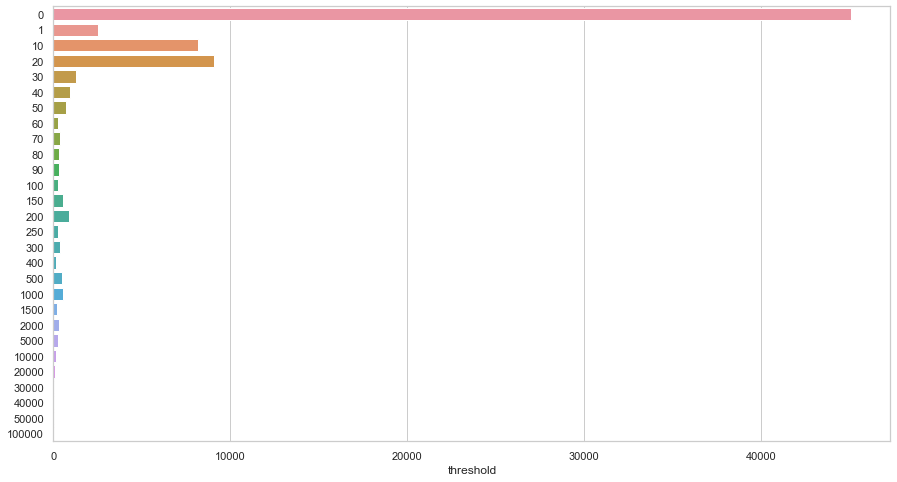

In [20]:
fig, ax = plt.subplots(1, figsize=(15,8))
sns.barplot(y=new_y_train.threshold.unique(), x=new_y_train.threshold.value_counts());

CPU times: user 5min 50s, sys: 1.49 s, total: 5min 52s
Wall time: 44.1 s


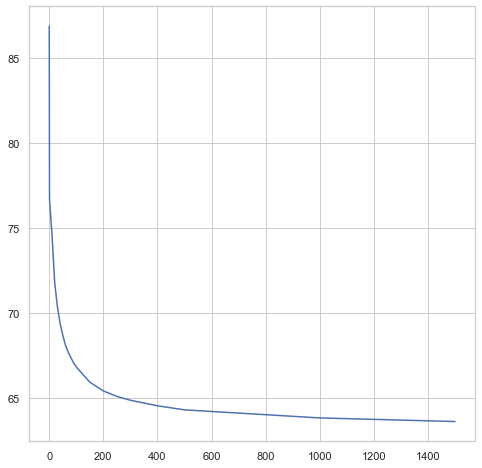

In [21]:
%%time

# put -1 for every BA>1500 as an extreme
new_y_train = pd.Categorical(pd.cut(y_train.BA, bins=[-1]+u_BA[0:20], right=True, labels=u_BA[0:20])).add_categories(-1).fillna(-1)
new_y_train = pd.DataFrame(new_y_train, columns=['threshold'], index=y_train.index)
new_y_test = pd.Categorical(pd.cut(y_test.BA, bins=[-1]+u_BA[0:20], right=True, labels=u_BA[0:20])).add_categories(-1).fillna(-1)
new_y_test = pd.DataFrame(new_y_test, columns=['threshold'], index=y_test.index)

clf = MLPClassifier(random_state=42, max_iter=300, activation='relu', alpha=0.0001, learning_rate='adaptive')
clf.fit(X_train.drop('CNT', axis=1), new_y_train.threshold)

scores = [100*clf.score(X_test[y_test.BA<=lv].drop('CNT', axis=1), 
                        new_y_test[y_test.BA<=lv].threshold) for lv in u_BA[0:20]]

plt.figure(figsize=(8,8))
plt.plot(u_BA[0:20], scores);

## SMOTE : Classification Balance
MLP don't have a balance option so we use SMOTE to oversample the training set such that we classes are perfectly balanced

In [ ]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=42)

X_sm, y_sm = sm.fit_resample(X_train[new_y_train.threshold!=-1], new_y_train[new_y_train.threshold!=-1].threshold.cat.remove_categories(-1))

print(f'''Shape of X before SMOTE: {X_train.shape}
Shape of X after SMOTE: {X_sm.shape}''')

print('\nBalance of positive and negative classes (%):')
y_sm.value_counts(normalize=True) * 100

In [ ]:
# select random 80k for now wuth class balance preserved
ind_sm = X_sm.sample(frac=0.2, random_state=42).index
print(len(ind_sm))
y_sm.loc[ind_sm].value_counts(normalize=True) * 100

In [ ]:
%%time

clf = MLPClassifier(max_iter=300, activation='relu', alpha=0.0001, learning_rate='adaptive', hidden_layer_sizes=100, random_state=42)
clf.fit(X_sm.loc[ind_sm].drop('CNT', axis=1), y_sm.loc[ind_sm])

ba_distribution = pd.DataFrame(clf.predict_proba(X_test.drop('CNT', axis=1)), columns=y_sm.unique().categories).cumsum(axis=1)
ba_distribution.to_csv('prediction_ba.csv', index=False)

# SCORE=

In [ ]:
scores = [100*clf.score(X_test[y_test.BA<=lv].drop('CNT', axis=1), new_y_test[y_test.BA<=lv].threshold) for lv in u_BA]

fig, ax = plt.subplots(1,2, figsize=(15,8))
ax[0].plot(u_BA, scores)
ax[1].plot(u_BA[0:15], scores[0:15]);

# Model Idea 1
1. classify BA is 0 or not
2. classify BA>0 using MLP and SMOTE

#### Step 1 : probability BA=0 (True) and BA>0 (False)

In [ ]:
%%time

#sm = SMOTE(random_state=42)
#X_sm, y_sm = sm.fit_resample(X_train, y_train==0)
#clf0 = MLPClassifier(max_iter=300, activation='relu', alpha=0.0001, learning_rate='adaptive', hidden_layer_sizes=100, random_state=42)

clf0 = RandomForestClassifier(max_depth=6, n_estimators=500, n_jobs=8, bootstrap=False, max_features=None, class_weight='balanced', random_state=42)
pipe0 = Pipeline([('pca', PCA(n_components=None, random_state=42)), ('clf', clf0)])

clf0.fit(X_train.drop(['CNT','year'], axis=1), y_train.BA==0)

In [ ]:
plt.figure(figsize=(8,6))
sns.heatmap(confusion_matrix(y_test.BA==0, clf0.predict(X_test.drop(['CNT','year'], axis=1)), normalize='true'), annot=True, cmap='Blues');

In [ ]:
p0 = pd.DataFrame(clf0.predict_proba(X_test.drop(['CNT','year'], axis=1))[:,1])
p0.T

#### Step 2 : classify BA>0

In [ ]:
fig, ax = plt.subplots(1, figsize=(15,8))
sns.barplot(y=new_y_train[y_train.BA!=0].threshold.unique(), 
            x=new_y_train[y_train.BA!=0].threshold.cat.remove_categories(0).value_counts());

In [ ]:
%%time

sm1 = SMOTE(random_state=42)
X_sm1, y_sm1 = sm1.fit_resample(X_train[y_train.BA!=0], new_y_train[y_train.BA>0])

print(f'''Shape of X before SMOTE: {X_train[y_train.BA!=0].shape}
Shape of X after SMOTE: {X_sm1.shape}''')

print('\nBalance of positive and negative classes (%):')
y_sm1.value_counts(normalize=True) * 100

In [ ]:
%%time

clf1 = MLPClassifier(max_iter=300, activation='relu', alpha=0.0001, learning_rate='adaptive', hidden_layer_sizes=100, random_state=42)
clf1.fit(X_sm1.drop('CNT', axis=1), y_sm1.threshold)

In [ ]:
ba_distribution = pd.DataFrame(clf1.predict_proba(X_test.drop('CNT', axis=1)), columns=u_BA[1:])
ba_distribution = ba_distribution.apply(lambda x: (1-p0[0][x.index])*x)
ba_distribution.insert(0, '0', p0)
ba_distribution = ba_distribution.cumsum(axis=1)
ba_distribution.to_csv('prediction_ba.csv', index=False)
ba_distribution